<a href="https://colab.research.google.com/github/BITHAL04/HATE-SPEECH-DETECTION/blob/main/HATE_SPEECH_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
dataset = pd.read_csv("/content/labeled_data.csv")

dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
dataset.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [ ]:
df = dataset[['class', 'tweet']]
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
class_counts = df['class'].value_counts()
class_counts

,count
class,
1,19190
2,4163
0,1430


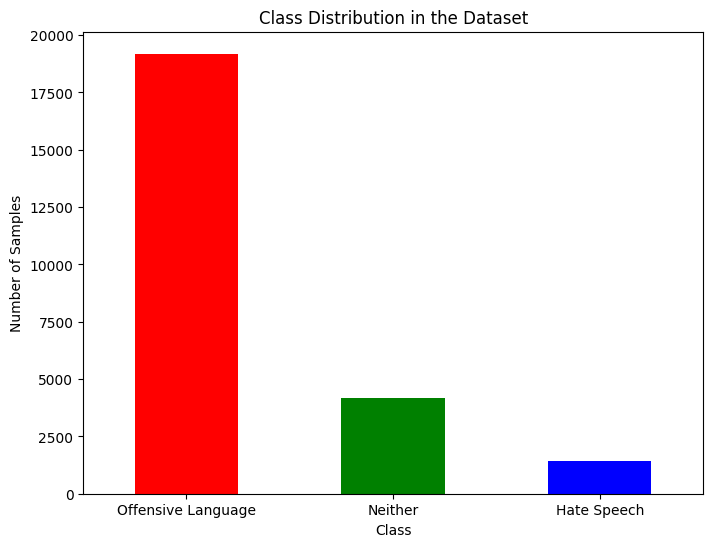

In [ ]:
import matplotlib.pyplot as plt

class_labels = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}

plt.figure(figsize=(8, 6))
class_counts.rename(index=class_labels).plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [ ]:
min_class_size = class_counts.min() #  1430

# Sample each class to match the smallest class size
df_class_0 = df[df['class'] == 0].sample(min_class_size, random_state=42)
df_class_1 = df[df['class'] == 1].sample(min_class_size, random_state=42)
df_class_2 = df[df['class'] == 2].sample(min_class_size, random_state=42)

# Combine the sampled data
df_balanced = pd.concat([df_class_0, df_class_1, df_class_2])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution
print(df_balanced['class'].value_counts())

class
2    1430
1    1430
0    1430
Name: count, dtype: int64


In [ ]:
df_balanced

,class,tweet
0,2,&#8220;@AdderallHadMe: Adderall had me killing...
1,1,@WendyDavisTexas msnbc the same MSM who said b...
2,2,"""@TEE_JONEZ: @KingCuh @16stanleys I'm not mad ..."
3,2,Jihadi propaganda ploy:US had Gulf countries p...
4,2,Defiantly going to see that new planet of the ...
...,...,...
4285,2,Video: Shy Glizzy &#8211; &#8220;I Can&#8217;t...
4286,0,@Matt_Petrie22 geta Life faggot
4287,2,@JunDishes get a can of WASP SPRAY. it shoots ...
4288,2,RT @antoinetteA: Coming up at 5:15a: Charlie B...


In [ ]:
df_balanced.iloc[1:5]

,class,tweet
1,1,@WendyDavisTexas msnbc the same MSM who said b...
2,2,"""@TEE_JONEZ: @KingCuh @16stanleys I'm not mad ..."
3,2,Jihadi propaganda ploy:US had Gulf countries p...
4,2,Defiantly going to see that new planet of the ...


In [ ]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Initialize the Porter Stemmer
ps = PorterStemmer()

# Initialize stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')  # Keep 'not' as it is important in negation

def clean_and_preprocess_text(text):

    # Remove 'RT' (Retweet indicator)
    text = re.sub(r'\bRT\b', '', text)

    # Remove URLs (Optional: you can keep this if needed)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove Twitter handles (Optional: you can keep this if needed)
    text = re.sub(r'@\w+', '', text)

    # Remove non-alphabetic characters (keep spaces)
    text = re.sub('[^a-zA-Z\s]', ' ', text)


    # Convert to lowercase
    text = text.lower()

    # Tokenize the text (split into words)
    words = text.split()

    # Remove stopwords and apply stemming
    words = [ps.stem(word) for word in words if word not in all_stopwords]

    # Rejoin the words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text

In [ ]:
df_balanced.loc[:, 'x'] = df['tweet'].apply(clean_and_preprocess_text)

df_balanced.head()

,class,tweet,x
0,2,&#8220;@AdderallHadMe: Adderall had me killing...,woman complain clean hous amp man alway take t...
1,1,@WendyDavisTexas msnbc the same MSM who said b...,boy dat cold tyga dwn bad cuffin dat hoe st place
2,2,"""@TEE_JONEZ: @KingCuh @16stanleys I'm not mad ...",dawg ever fuck bitch start cri confus shit
3,2,Jihadi propaganda ploy:US had Gulf countries p...,look like tranni
4,2,Defiantly going to see that new planet of the ...,shit hear might true might faker bitch told ya


In [ ]:
y = df_balanced["class"].values
x = df_balanced["x"].values

In [ ]:
y[1:5]

array([1, 2, 2, 2])

In [ ]:
print("shape of x: ", x.shape,"\nshape of y: ",y.shape)

shape of x:  (4290,) 
shape of y:  (4290,)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

MAX_FEATURES = 200000 # number of words in the vocab

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=1000,
)

model = tf.keras.Sequential([
    # TextVectorization layer to preprocess the raw text
    vectorizer,

    # Embedding layer (use the size of the vocabulary for the input_dim)
    tf.keras.layers.Embedding(MAX_FEATURES + 1, 32),

    # Bidirectional LSTM Layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    Dropout(0.3),  # Dropout after the second LSTM layer
    # Fully connected layers (Feature Extractors)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

     # Final output layer with 3 neurons for 3 classes, using softmax
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: 0, 1, 2
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
    metrics=['accuracy']
)

In [ ]:
vectorizer.adapt(x)

In [ ]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.3251 - loss: 1.1001 - val_accuracy: 0.3738 - val_loss: 1.0986
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3488 - loss: 1.0984 - val_accuracy: 0.3762 - val_loss: 1.0927
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.4089 - loss: 1.0727 - val_accuracy: 0.4847 - val_loss: 0.9945
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.4542 - loss: 1.0780 - val_accuracy: 0.3443 - val_loss: 1.0971
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.3382 - loss: 1.0964 - val_accuracy: 0.3679 - val_loss: 1.0801
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.3816 - loss: 1.0856 - val_accuracy: 0.3856 - val_loss: 1.0664
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.4403 - loss: 1.0452 - val_accuracy: 0.4540 - val_loss: 0.9777
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.5227 - loss: 0.9362 - 

<Figure size 800x500 with 0 Axes>

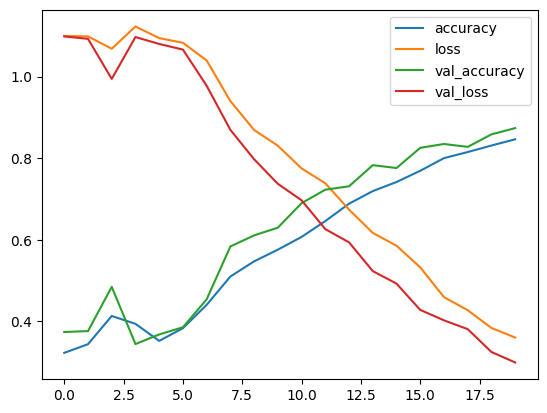

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
y_true_list = []
yhat_list = []

for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = np.argmax(model.predict(X_true), axis=-1)


    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    y_true_list.append(y_true)
    yhat_list.append(yhat)

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9101123809814453, Recall:0.927480936050415, Accuracy:0.9230769276618958


In [ ]:
F1_score = 2 * ((pre.result().numpy() * re.result().numpy())  / (pre.result().numpy() + re.result().numpy()))

F1_score

0.9187145233154297

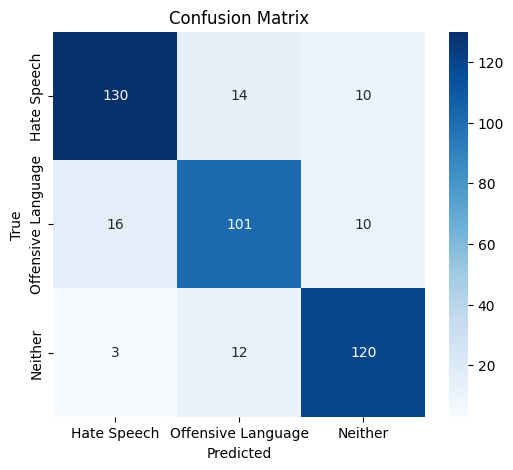

In [ ]:
y_true_all = np.concatenate(y_true_list)
yhat_all = np.concatenate(yhat_list)

# Compute the confusion matrix
cm = confusion_matrix(y_true_all, yhat_all)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Hate Speech', 'Offensive Language', 'Neither'],
            yticklabels=['Hate Speech', 'Offensive Language', 'Neither'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('my_model.keras')